# **Prediction of X-day ICU readmission**
    NGUYEN Dinh-Phong
    DIM HuPS / AP-HP WIND
    
Walkthrough notebook on prediction of ICU readmission, documenting the steps to reproduce the results of :

Needs Spark v2.3.0

*NB: to launch everything in one go instead of a cell-by-cell walkthrough, please refer to the end of this notebook after importing the packages and instantiating the parameters*

## **Importing packages**

In [1]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
import missingno as msno
# import tableone

%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

from omopML import *

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, QuantileTransformer
)


In [2]:
import warnings
warnings.filterwarnings('ignore')

## **Instantiating parameters**

In [27]:
# OMOP tables to keep and their columns
tables_dict = {
    "person": [
        "person_id", 
        "gender_concept_id", 
        "year_of_birth", 
        "month_of_birth", 
        "day_of_birth", 
        "birth_datetime", 
        "race_concept_id", 
        "ethnicity_concept_id", 
    ],
    "care_site": [
        "care_site_id",
        "care_site_name",
    ],
    "visit_occurrence": [
        "visit_occurrence_id",
#         "visit_type_concept_id",
        "person_id",
#         "visit_start_date",
#         "visit_end_date"
    ],
    "visit_detail": [
        "visit_detail_id",
        "care_site_id",
        "visit_occurrence_id",
        "visit_detail_concept_id",
        "visit_type_concept_id",
        "preceding_visit_detail_id",
        "visit_start_date",
        "visit_end_date",
        "discharge_to_concept_id",
    ],
    "measurement": [
        "measurement_id",
        "visit_occurrence_id",
        "visit_detail_id",
        "measurement_concept_id",
        "measurement_datetime",
        "measurement_type_concept_id",
        "value_as_number",
    ],
    "note": [
        "note_id",
        "person_id",
        "note_date"
    ],
    "note_nlp": [
        "note_id",
        "lexical_variant"
    ]
}

# Optional filter conditions
conditions_dict = {}

# Measurement names and their OMOP ID
measurements_dict = {
    "glasgow_motor": 3008223,
    "glasgow_verbal": 3009094,
    "glasgow_eye": 3016335,
    "systolic_bp": 3004249,
    "heart_rate": 3027018,
    "resp_rate": 3024171,
    "body_temp": 3020891,
    "sao2": 3016502,
    "fio2": 3020716,
    "body_weight": 3025315,
    "urine_output": 3014315,
    "serum_bicarbonate": 3016293,
    "serum_urea": 3013682,
    "total_bilirubin": 3024128,
    "direct_bilirubin": 3027597,
    "indirect_bilirubin": 3007359,
    "serum_sodium": 3019550,
    "serum_potassium": 3023103,
    "serum_creatinine": 3016723,
    "blood_platelets": 3024929,
    "blood_hemoglobin": 3000963,
    "blood_hematocrit": 3023314,
    "blood_leukocytes": 3003282,
    "serum_lactates": 3047181,
    "blood_ph": 3010421,
    "blood_glucose": 3004501,
    "INR": 3022217,
}

# Features types
features_dict = {
    "gender": np.bool,
    "length_of_stay": np.int32,
    "age": np.int32,
    "visit_detail_rank": np.int32,
    "first_glasgow_total": np.int32,
    "first_glasgow_motor": np.int32,
    "first_glasgow_verbal": np.int32,
    "first_glasgow_eye": np.int32,
    "first_systolic_bp": np.int32,
    "first_heart_rate": np.int32,
    "first_resp_rate": np.int32,
    "first_body_temp": np.float32,
    "first_sao2": np.float32,
    "first_fio2": np.float32,
    "first_body_weight": np.float32,
    "first_urine_output": np.float32,
    "first_serum_bicarbonate": np.float32,
    "first_serum_urea": np.float32,
    "first_total_bilirubin": np.float32,
    "first_serum_sodium": np.float32,
    "first_serum_potassium": np.float32,
    "first_serum_creatinine": np.float32,
    "first_blood_platelets": np.float32,
    "first_blood_hemoglobin": np.float32,
    "first_blood_hematocrit": np.float32,
    "first_blood_leukocytes": np.float32,
    "first_serum_lactates": np.float32,
    "first_blood_ph": np.float32,
    "first_blood_glucose": np.float32,
    "first_INR": np.float32,
    "last_glasgow_total": np.int32,
    "last_glasgow_motor": np.int32,
    "last_glasgow_verbal": np.int32,
    "last_glasgow_eye": np.int32,
    "last_systolic_bp": np.int32,
    "last_heart_rate": np.int32,
    "last_resp_rate": np.int32,
    "last_body_temp": np.float32,
    "last_sao2": np.float32,
    "last_fio2": np.float32,
    "last_body_weight": np.float32,
    "last_urine_output": np.float32,
    "last_serum_bicarbonate": np.float32,
    "last_serum_urea": np.float32,
    "last_total_bilirubin": np.float32,
    "last_serum_sodium": np.float32,
    "last_serum_potassium": np.float32,
    "last_serum_creatinine": np.float32,
    "last_blood_platelets": np.float32,
    "last_blood_hemoglobin": np.float32,
    "last_blood_hematocrit": np.float32,
    "last_blood_leukocytes": np.float32,
    "last_serum_lactates": np.float32,
    "last_blood_ph": np.float32,
    "last_blood_glucose": np.float32,
    "last_INR": np.float32,
    "delta_glasgow_total": np.int32,
    "delta_glasgow_motor": np.int32,
    "delta_glasgow_verbal": np.int32,
    "delta_glasgow_eye": np.int32,
    "delta_systolic_bp": np.int32,
    "delta_heart_rate": np.int32,
    "delta_resp_rate": np.int32,
    "delta_body_temp": np.float32,
    "delta_sao2": np.float32,
    "delta_fio2": np.float32,
    "delta_body_weight": np.float32,
    "delta_urine_output": np.float32,
    "delta_serum_bicarbonate": np.float32,
    "delta_serum_urea": np.float32,
    "delta_total_bilirubin": np.float32,
    "delta_serum_sodium": np.float32,
    "delta_serum_potassium": np.float32,
    "delta_serum_creatinine": np.float32,
    "delta_blood_platelets": np.float32,
    "delta_blood_hemoglobin": np.float32,
    "delta_blood_hematocrit": np.float32,
    "delta_blood_leukocytes": np.float32,
    "delta_serum_lactates": np.float32,
    "delta_blood_ph": np.float32,
    "delta_blood_glucose": np.float32,
    "delta_INR": np.float32,
    "from_surgery": np.bool,
    "history_aids": np.bool,
    "history_metastases": np.bool,
    "history_hemato": np.bool,
    "full_count": np.int32
}

# Outcome parameters
label = "readmission"
time_to_readmission = 7

# Optional data normalizer
scaler = QuantileTransformer(n_quantiles=20, output_distribution="uniform")

seed = 42

## **Detailed walkthrough**

## Loading data

In [4]:
%%time
# loader = DataLoader("mimicomop", "5.3.1", tables_dict, measurements_dict)
# loader.load(sqlContext)
# loader.filter(conditions_dict)
# loader.create_dataset(sqlContext)
# loader.dataset.write.parquet("output/data_mimicomop.parquet", mode="overwrite")
df = pd.read_parquet("output/data_mimicomop.parquet")
df = df.drop_duplicates(["person_id", "visit_start_date"])

CPU times: user 7.21 s, sys: 1.08 s, total: 8.29 s
Wall time: 1.88 s


## Adding study specific features

In [5]:
df.describe()

person_id  visit_occurrence_id  visit_detail_id  \
count  6.771900e+04         67719.000000     6.771900e+04   
mean   6.208639e+07         29569.361745     6.696910e+07   
std    1.337857e+04         17036.168164     7.563650e+04   
min    6.206337e+07             1.000000     6.683784e+07   
25%    6.207480e+07         14875.500000     6.690359e+07   
50%    6.208631e+07         29650.000000     6.696920e+07   
75%    6.209785e+07         44348.500000     6.703460e+07   
max    6.210989e+07         58976.000000     6.709973e+07   

       visit_detail_concept_id  discharge_to_concept_id  gender_concept_id  \
count                  67719.0             6.771900e+04       67719.000000   
mean                   32037.0             3.566122e+06        8517.961842   
std                        0.0             1.303760e+06          12.405093   
min                    32037.0             8.536000e+03        8507.000000   
25%                    32037.0             4.030023e+06        8507.000000   
50%                    32037.0             4.030023e+06        8507.000000   
75%                    32037.0             4.030023e+06        8532.000000   
max                    32037.0             4.216643e+06        8532.000000   

       year_of_birth  month_of_birth  day_of_birth  race_concept_id  ...  \
count   67719.000000    67719.000000  67719.000000     6.771900e+04  ...   
mean     2085.269998        6.502370     15.735229     4.803683e+06  ...   
std        63.224497        3.439153      8.808302     1.162900e+07  ...   
min      1800.000000        1.000000      1.000000     8.515000e+03  ...   
25%      2061.000000        4.000000      8.000000     8.527000e+03  ...   
50%      2093.000000        7.000000     16.000000     8.527000e+03  ...   
75%      2121.000000        9.000000     23.000000     4.188159e+06  ...   
max      2201.000000       12.000000     31.000000     3.800362e+07  ...   

       last_serum_creatinine  last_blood_platelets  last_blood_hemoglobin  \
count           57986.000000          61449.000000           61654.000000   
mean                1.391681            240.374634              10.919567   
std                 1.477398            136.064711               2.342450   
min                 0.000000              5.000000               0.000000   
25%                 0.700000            152.000000               9.300000   
50%                 0.900000            215.000000              10.500000   
75%                 1.400000            299.000000              12.000000   
max                29.100000           1846.000000              24.100000   

       last_blood_hematocrit  last_blood_leukocytes  last_serum_lactates  \
count           61554.000000           61047.000000         39360.000000   
mean               32.437513              11.723745             1.920835   
std                 6.606325               8.180431             1.841224   
min                 8.700000               0.100000             0.050000   
25%                28.100000               7.700000             1.100000   
50%                31.200000              10.500000             1.500000   
75%                35.400000              14.000000             2.100000   
max                70.000000             665.600000            30.000000   

       last_blood_ph  last_blood_glucose      last_INR  death_type_concept_id  
count   44674.000000        55064.000000  39187.000000           2.555700e+04  
mean        7.392599          132.176413      1.424333           1.565393e+07  
std         0.076798           55.774163      0.774201           1.870475e+07  
min         6.640000            2.000000      0.500000           2.610000e+02  
25%         7.350000          101.000000      1.100000           2.610000e+02  
50%         7.400000          120.000000      1.200000           2.610000e+02  
75%         7.440000          148.000000      1.400000           3.800357e+07  
max         7.720000         2202.000000     24.90000

In [6]:
# Gender
df["gender"] = (df["gender_concept_id"] == 8532)

# Age and age binning
df["age"] = df["visit_start_date"].dt.year - df["year_of_birth"]
df = df[df["age"] >= 18]
age_bins = [0, 18, 25, 45, 65, 85, 95, 350]
df["age"] = pd.cut(df["age"], age_bins, right=False, labels=False)

# Length of stay
df["length_of_stay"] = (df["visit_end_date"] - df["visit_start_date"]).dt.days

# Total GCS from parts
df["first_glasgow_total"] = np.sum(
    df[["first_glasgow_motor", "first_glasgow_verbal", "first_glasgow_eye"]],
    axis=1
)
df["last_glasgow_total"] = np.sum(
    df[["last_glasgow_motor", "last_glasgow_verbal", "last_glasgow_eye"]],
    axis=1
)

# Differences between first and last available measurement in ICU
for column in df.columns:
    if column[:5] == "first":
        df["delta_{}".format(column[6:])] = np.abs(df["last_{}".format(column[6:])] - df[column])

## Explorating correlations and missing data

In [28]:
preprocessor = Preprocessor(df, features_dict, label, time_to_readmission)

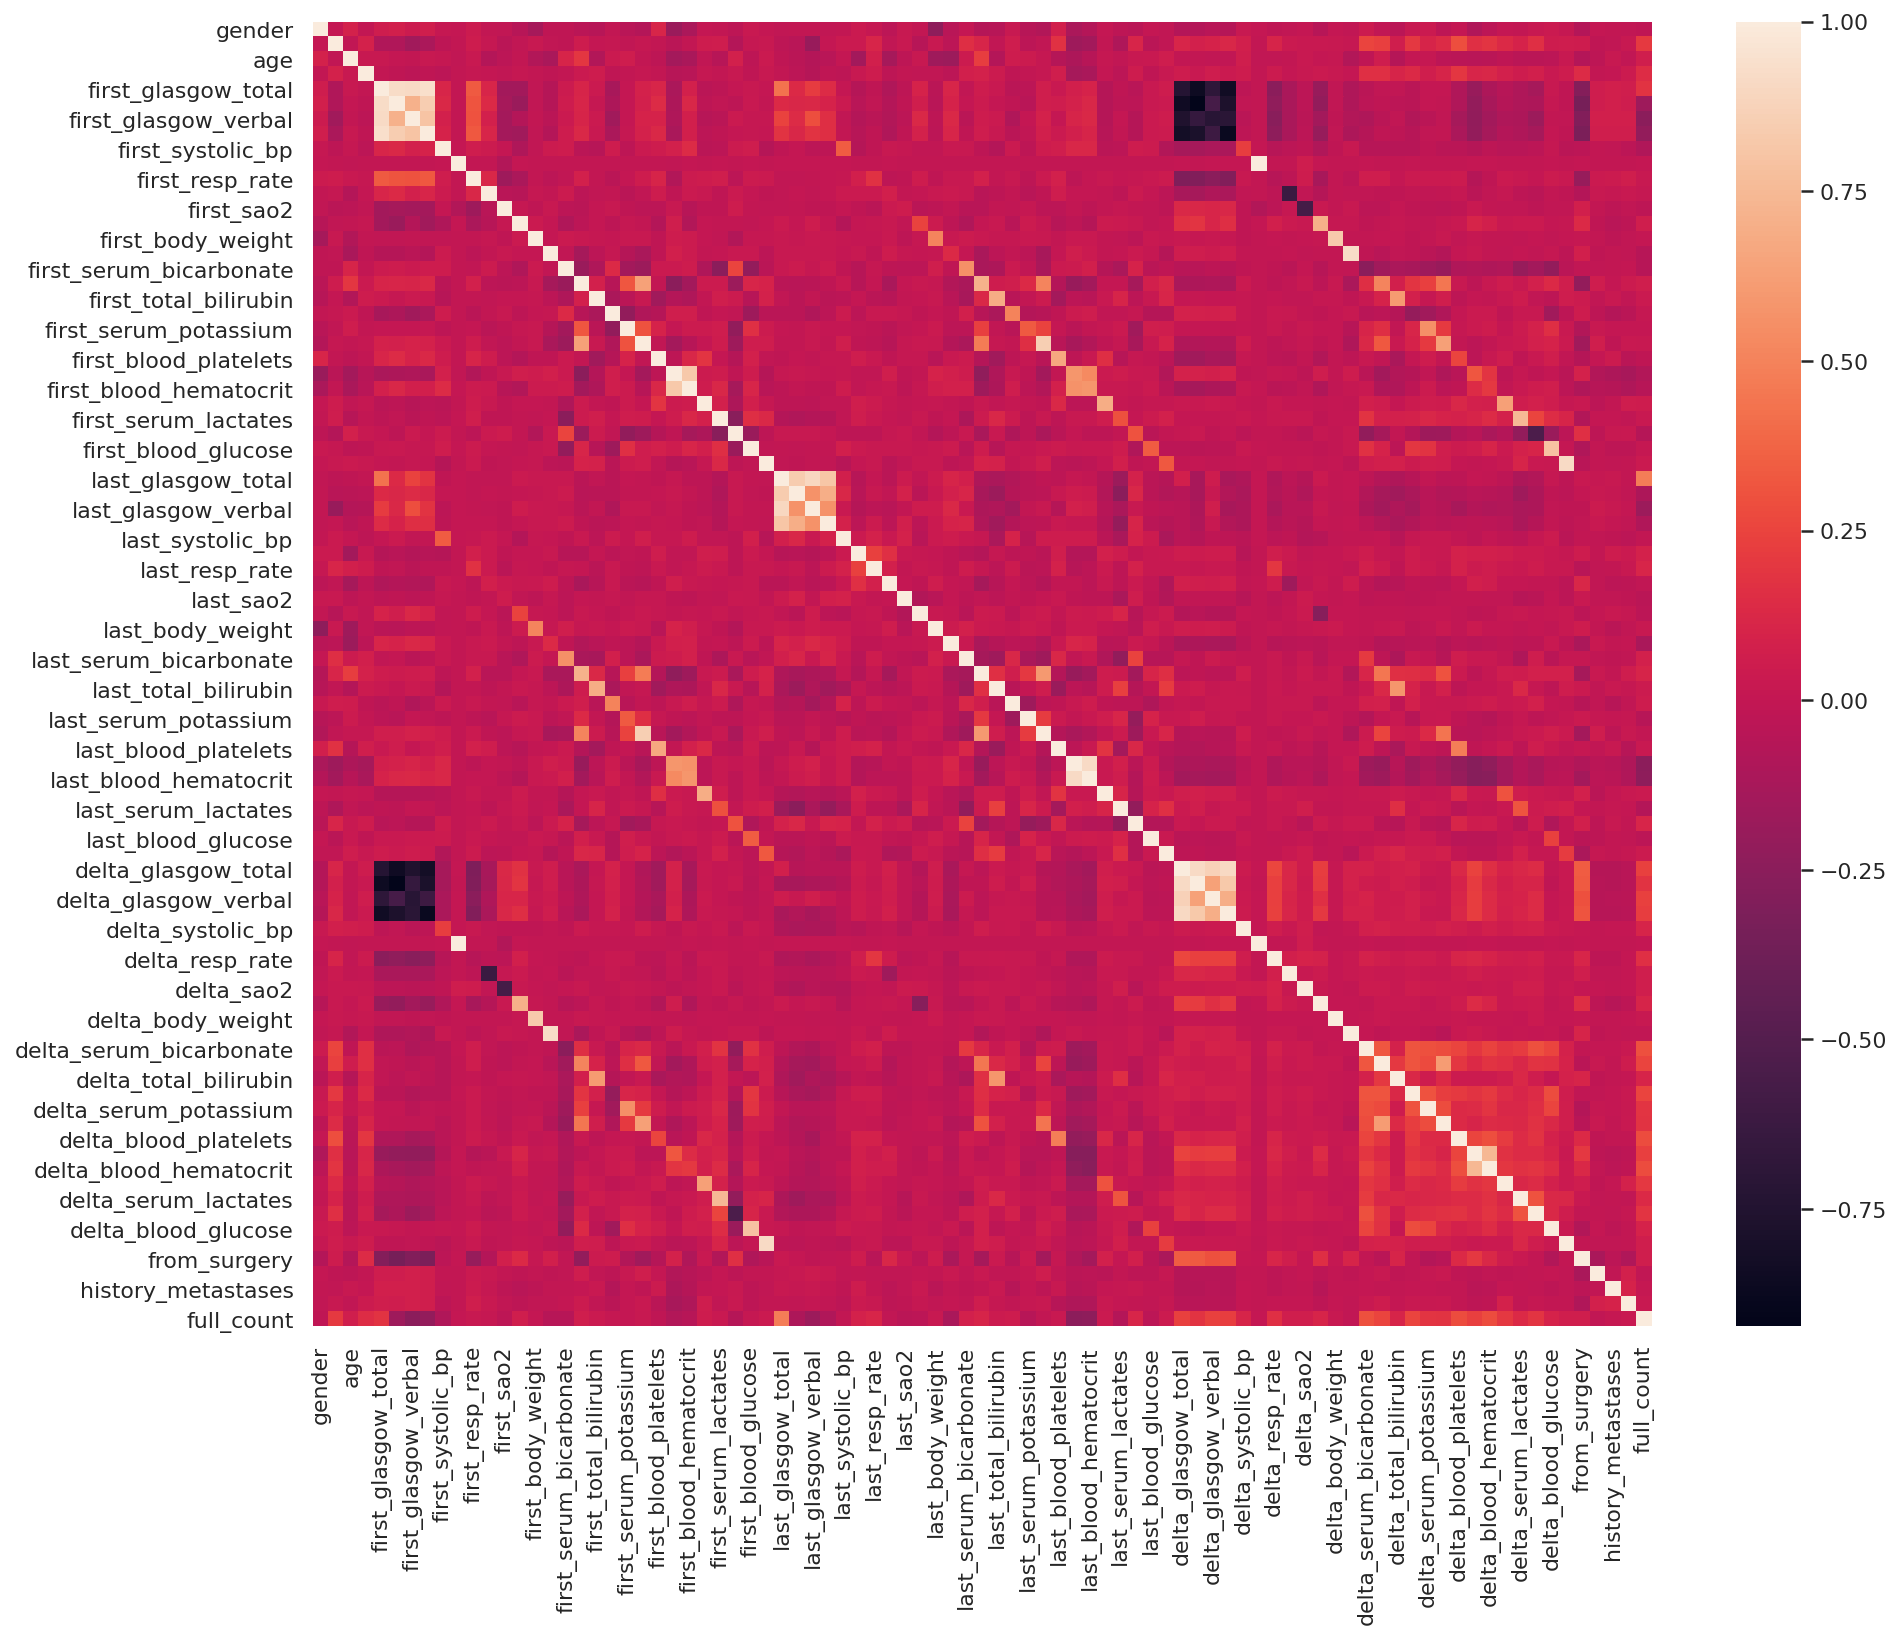

In [29]:
preprocessor.plot_corr_heatmap()

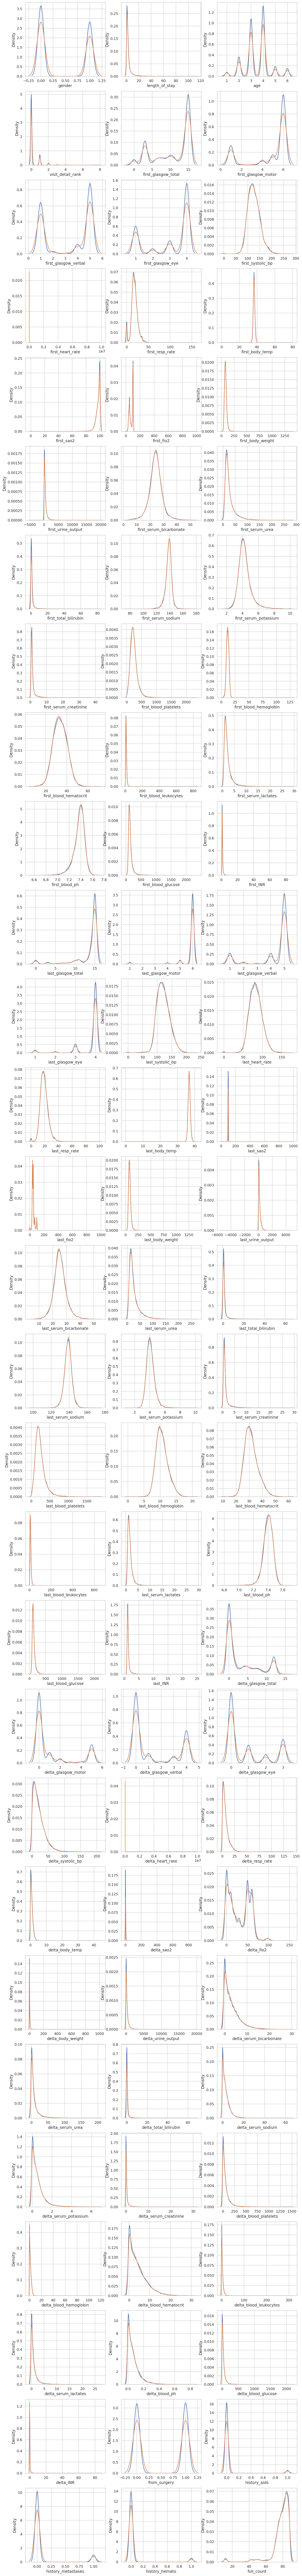

In [30]:
preprocessor.plot_dist_label()

## Missing data

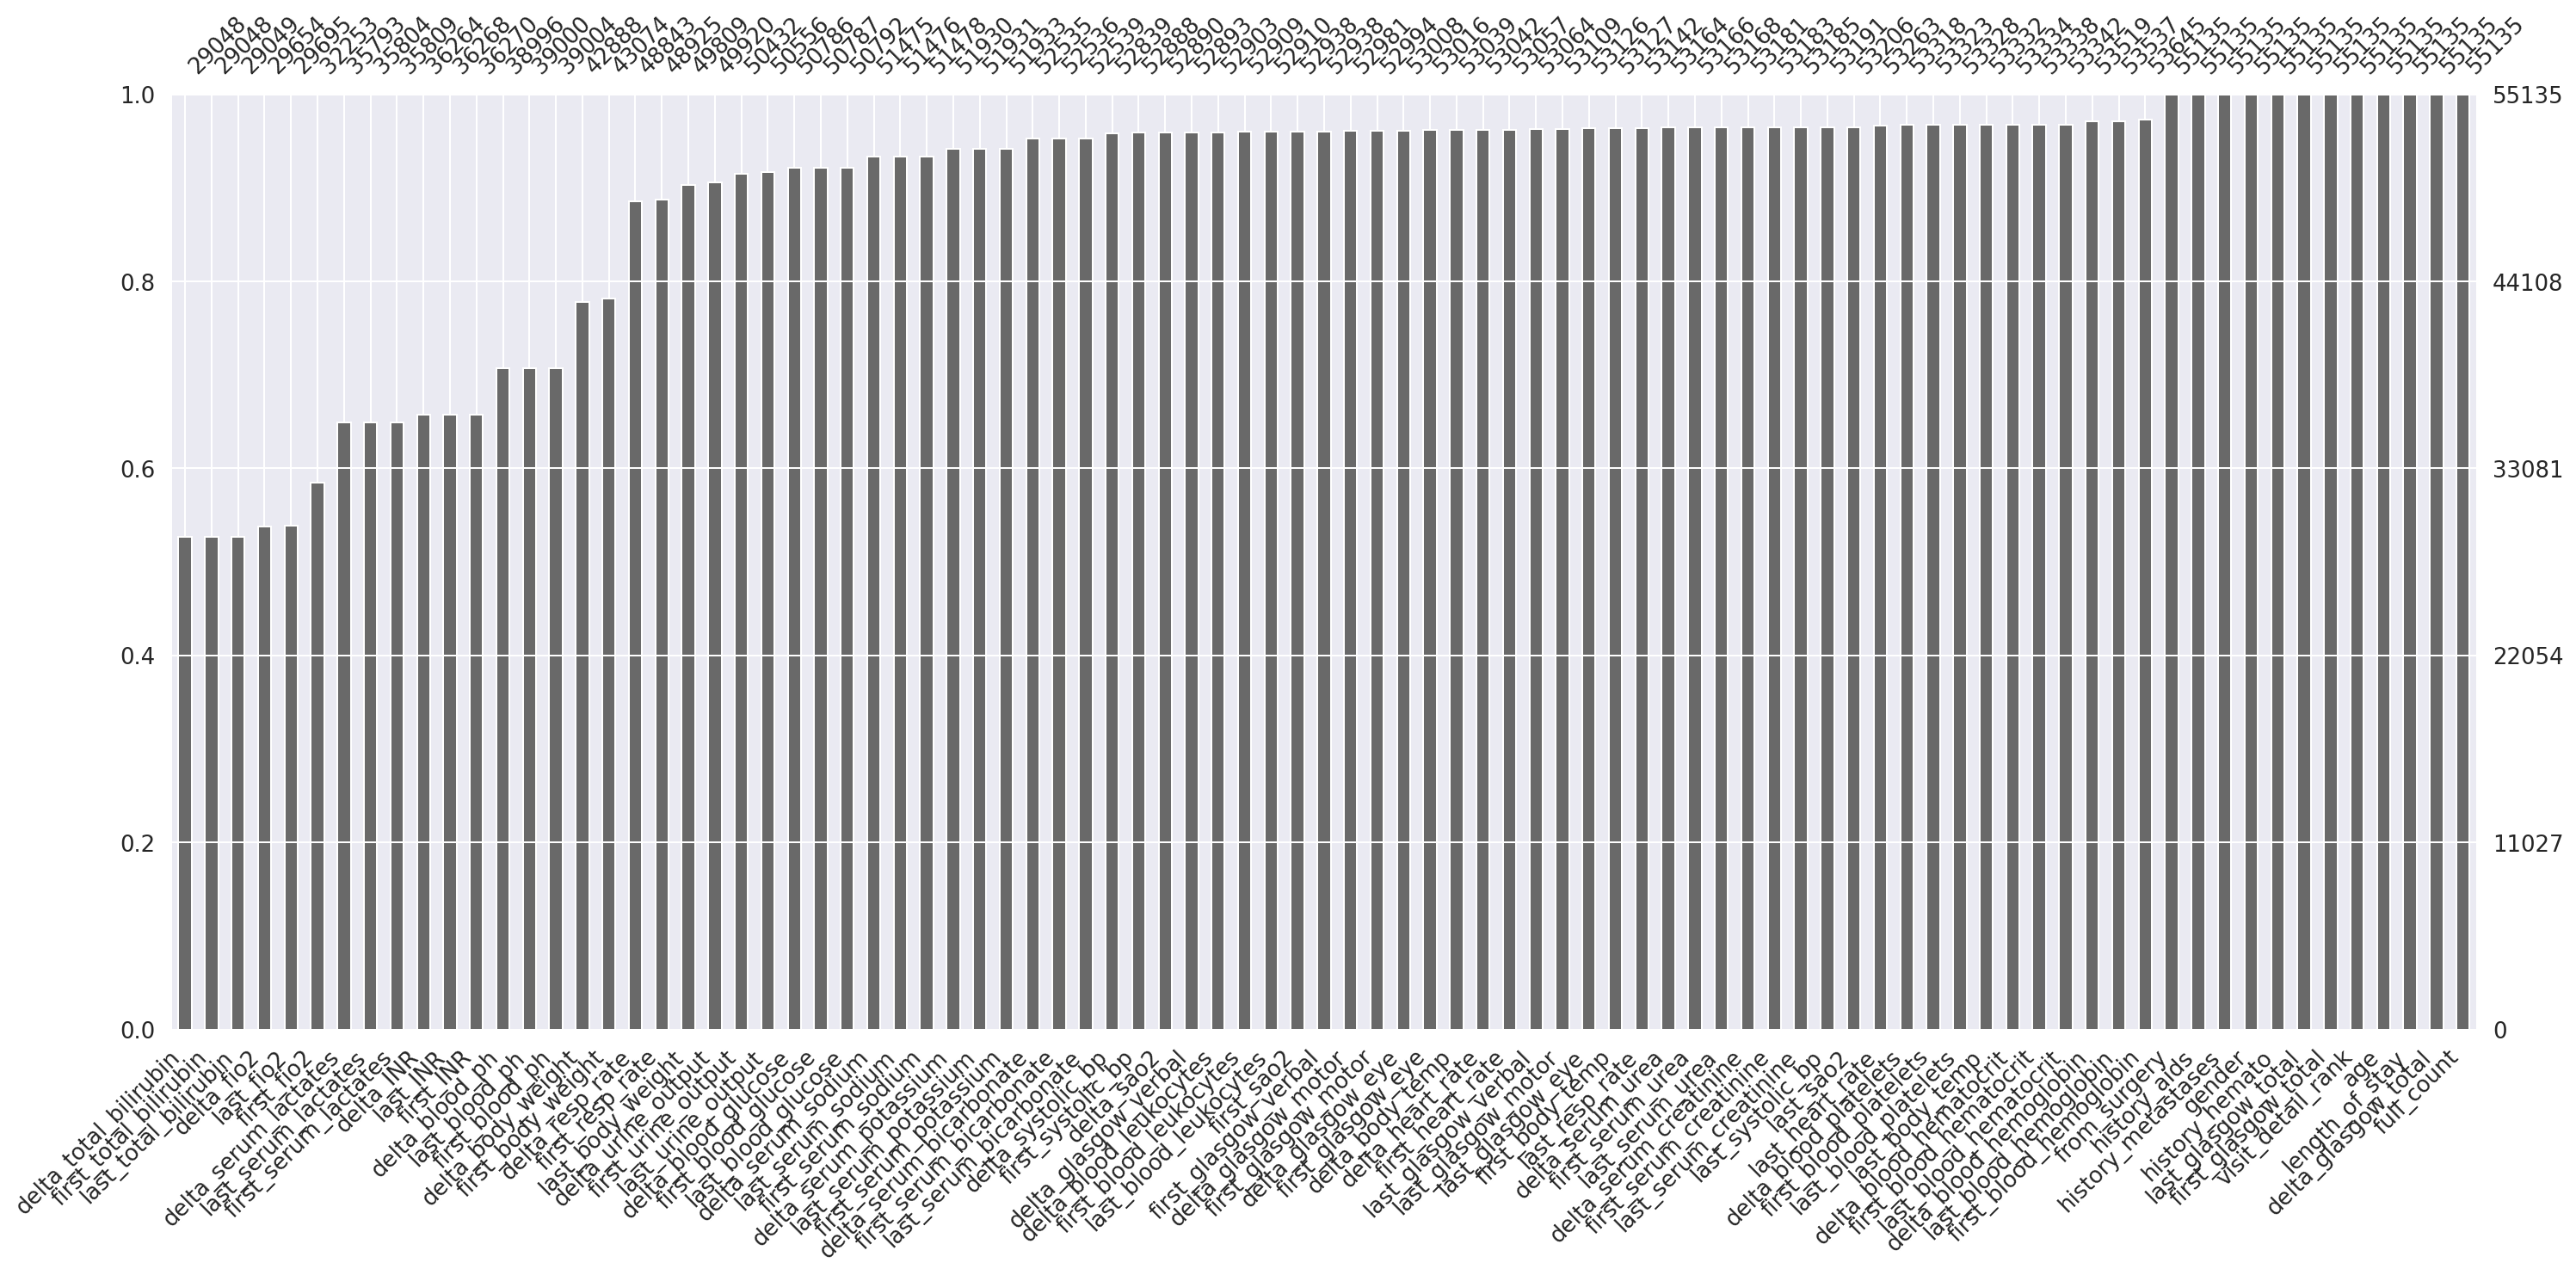

In [40]:
msno.bar(preprocessor.X, labels=True, sort="ascending", fontsize=13);

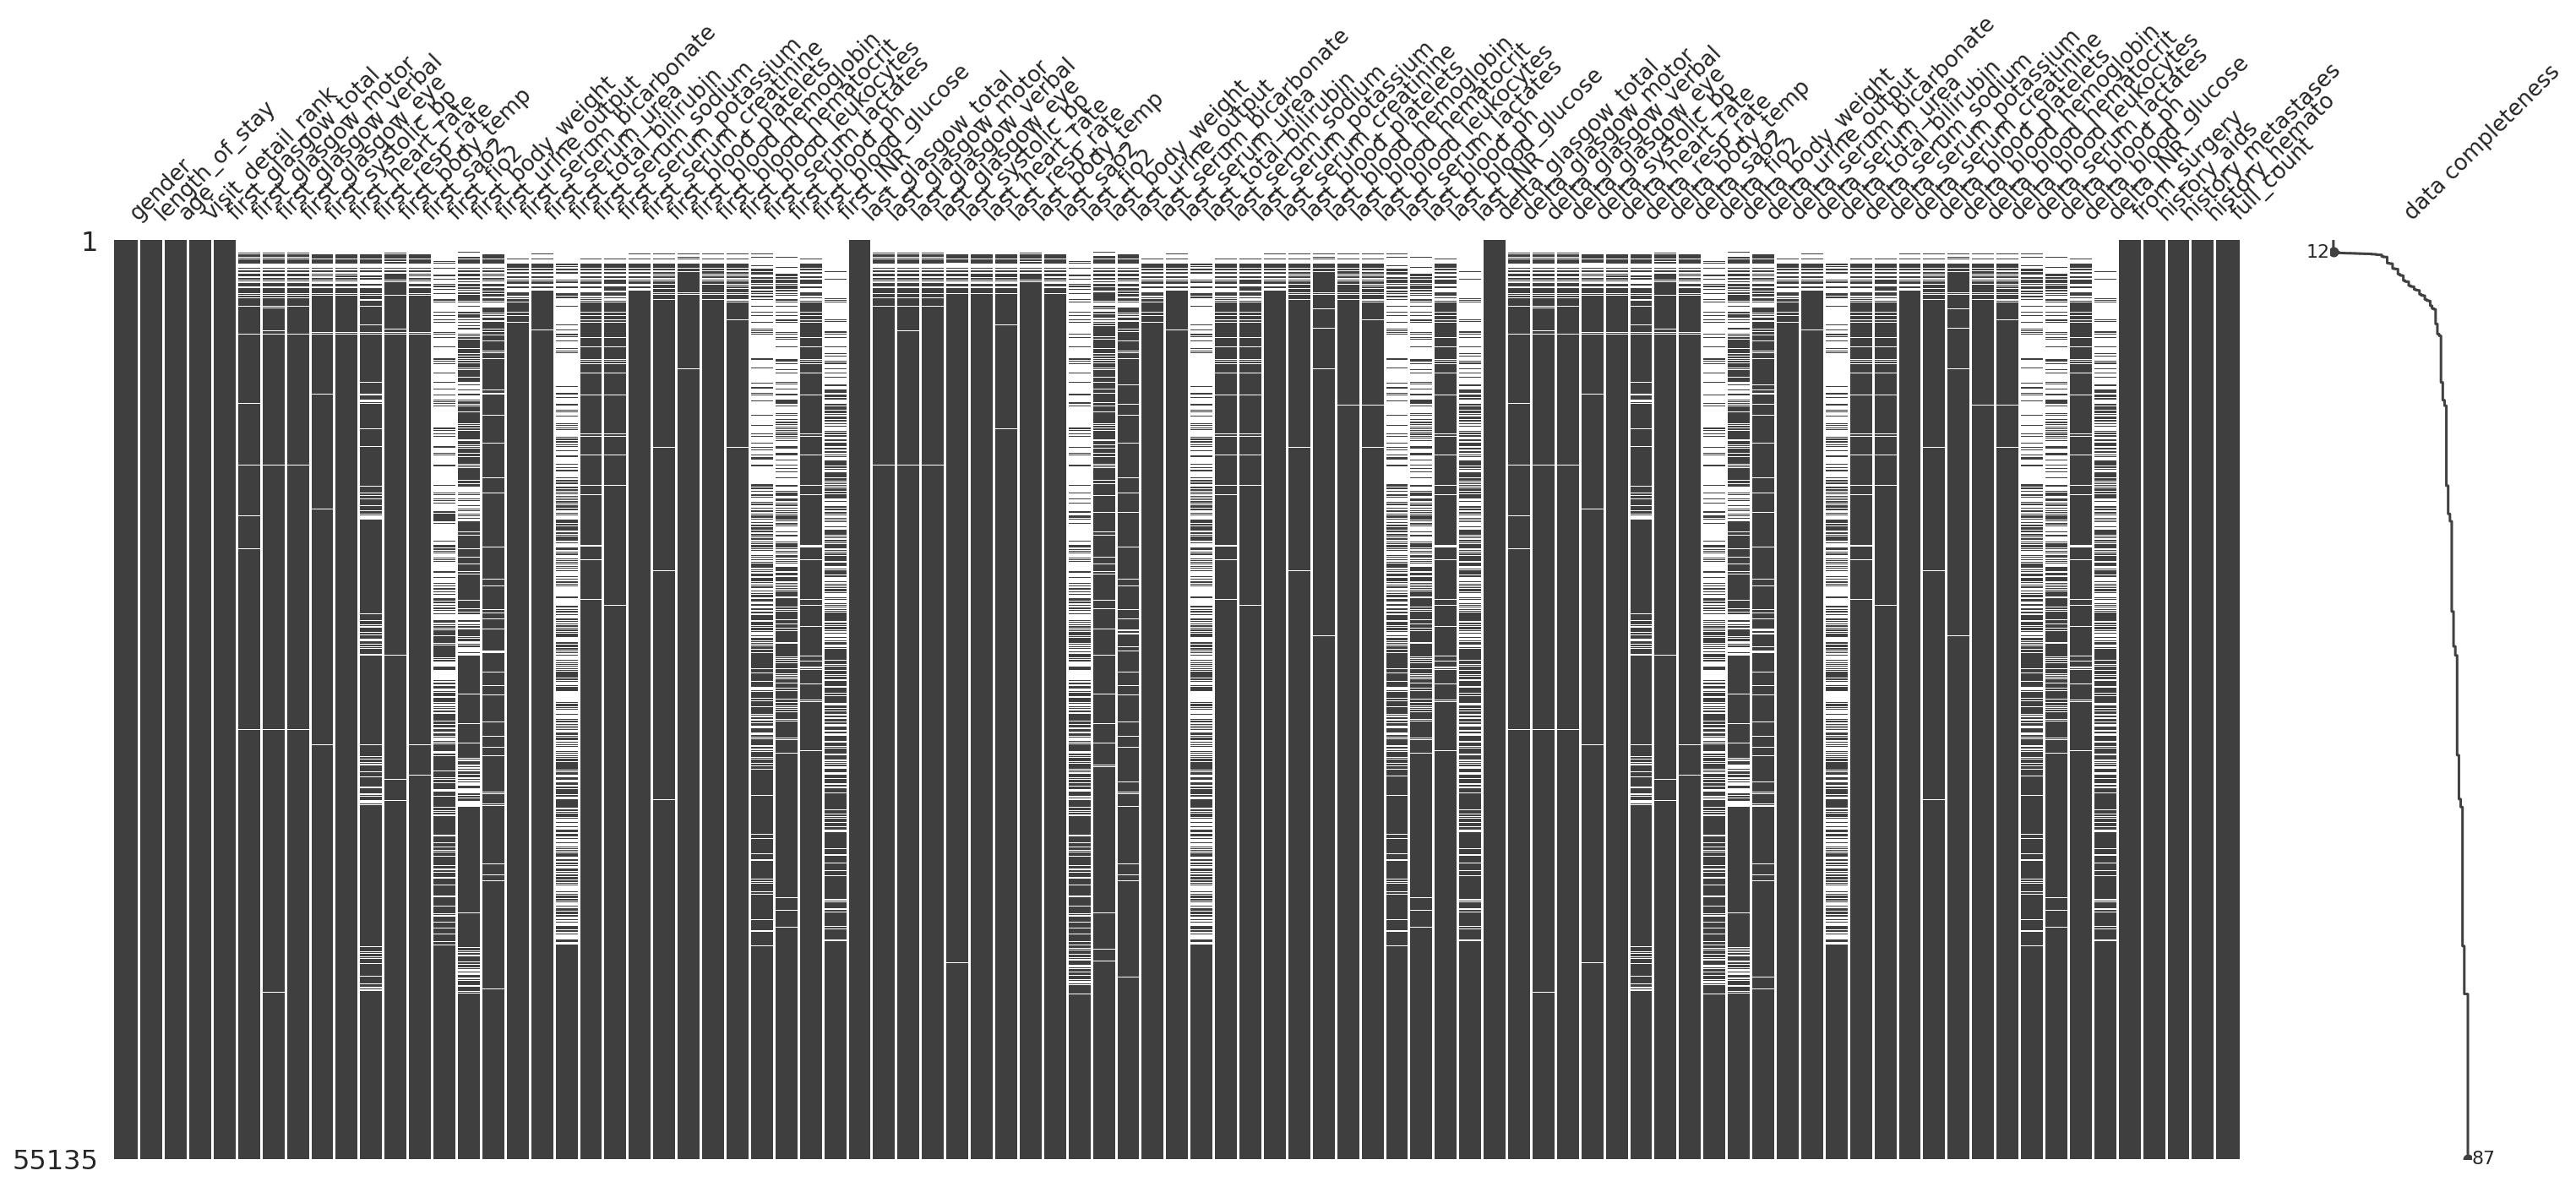

In [41]:
msno.matrix(preprocessor.X, labels=True, sort="ascending", fontsize=13);

## Preprocessing

In [31]:
X = preprocessor.fit_transform(preprocessor.X, preprocessor.y, imputing_strategy="iterative", scaler=scaler)
y = preprocessor.y

Training model...
Tuning thresholds to maximize f-1.5 score...
Precision: 0.4179
Sensitivity/Recall: 0.7146
Specificity: 0.7571
F1 score: 0.5274
ROC AUC: 0.8074
Accuracy: 0.7488
CPU times: user 13.9 s, sys: 307 ms, total: 14.2 s
Wall time: 6.03 s


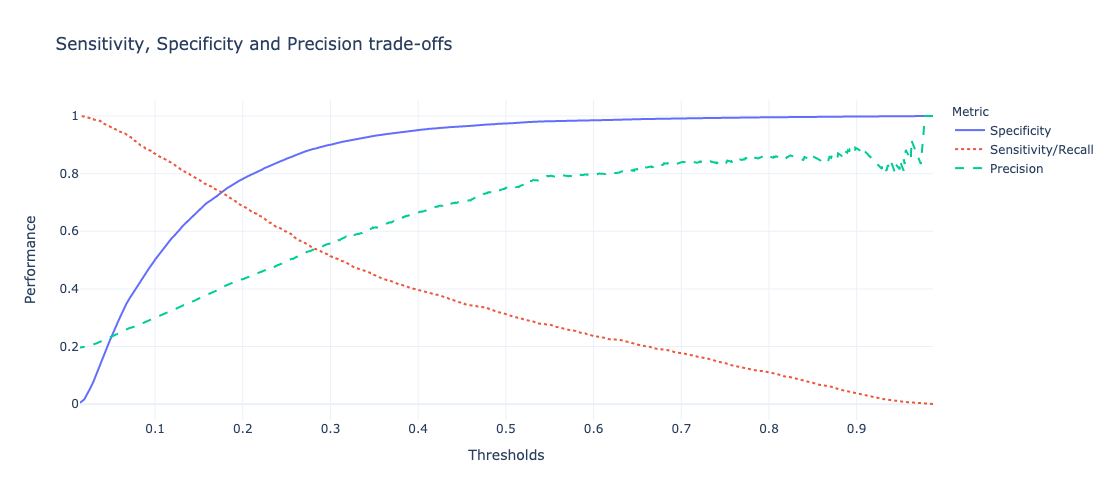

In [32]:
%%time
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "n_estimators": 200,
    "max_depth": 5,
    "learning_rate": 0.1,
    "colsample_bytree": 0.7,
    "random_state": seed,
    "gpu_id": 0,
    "tree_method": "gpu_hist",
}

trainer = SingleLabelTrainer(
    "icu_prediction",
    X,
    y,
    test_size=0.2,
    val_size=0.2,
    seed=seed,
)
trainer.train_model(xgb_params, early_stopping_rounds=20)
trainer.tune_thresholds(beta=1.5)
trainer.evaluate(trainer.y_test, trainer.probas, print_results=True)
trainer.plot_interactive_threshold(trainer.y_test, trainer.probas)

In [33]:
import plotly.io as pio
pio.kaleido.scope.mathjax = None

perfs = trainer.plot_interactive_threshold(
    trainer.y_test, trainer.probas, width=600, height=400
)
perfs.update_layout(
    font=dict(
        size=16,
        color="black"
    )
)

perfs.write_image(
    f"./output/{time_to_readmission}d-perfs-{datetime.today().strftime('%Y%m%d')}.png",
    width=600,
    height=400,
    engine="kaleido",
    scale=4,
)

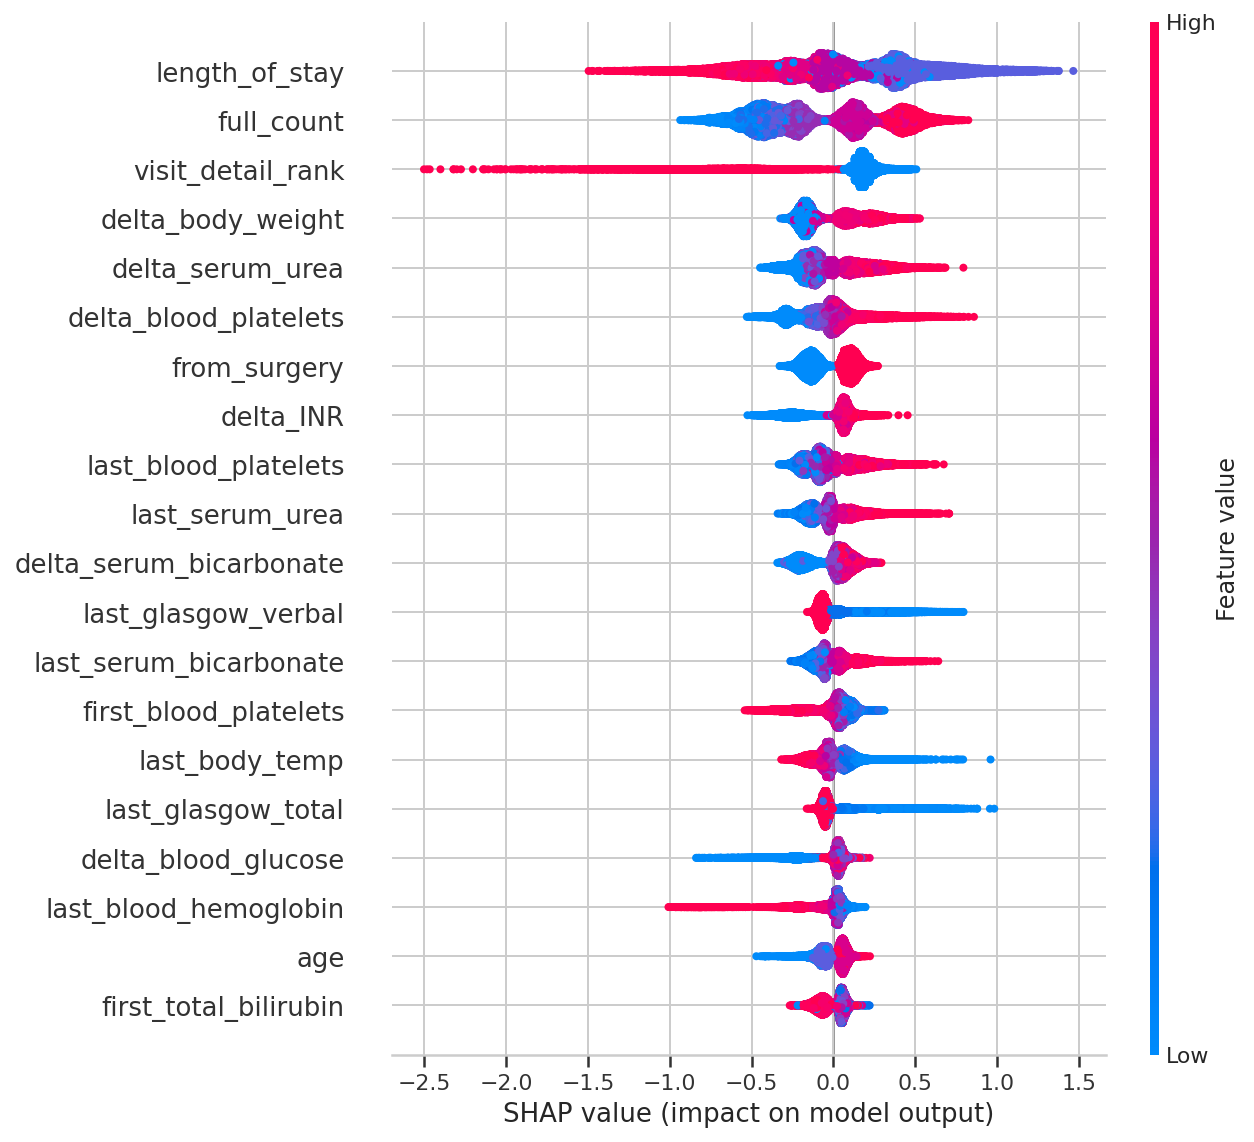

In [34]:
plt.figure(figsize=(12, 12))
trainer.plot_shap(trainer.X_train, show=False)
plt.savefig(f"./output/{time_to_readmission}d-shap-{datetime.today().strftime('%Y%m%d')}.png", dpi=300, bbox_inches="tight")

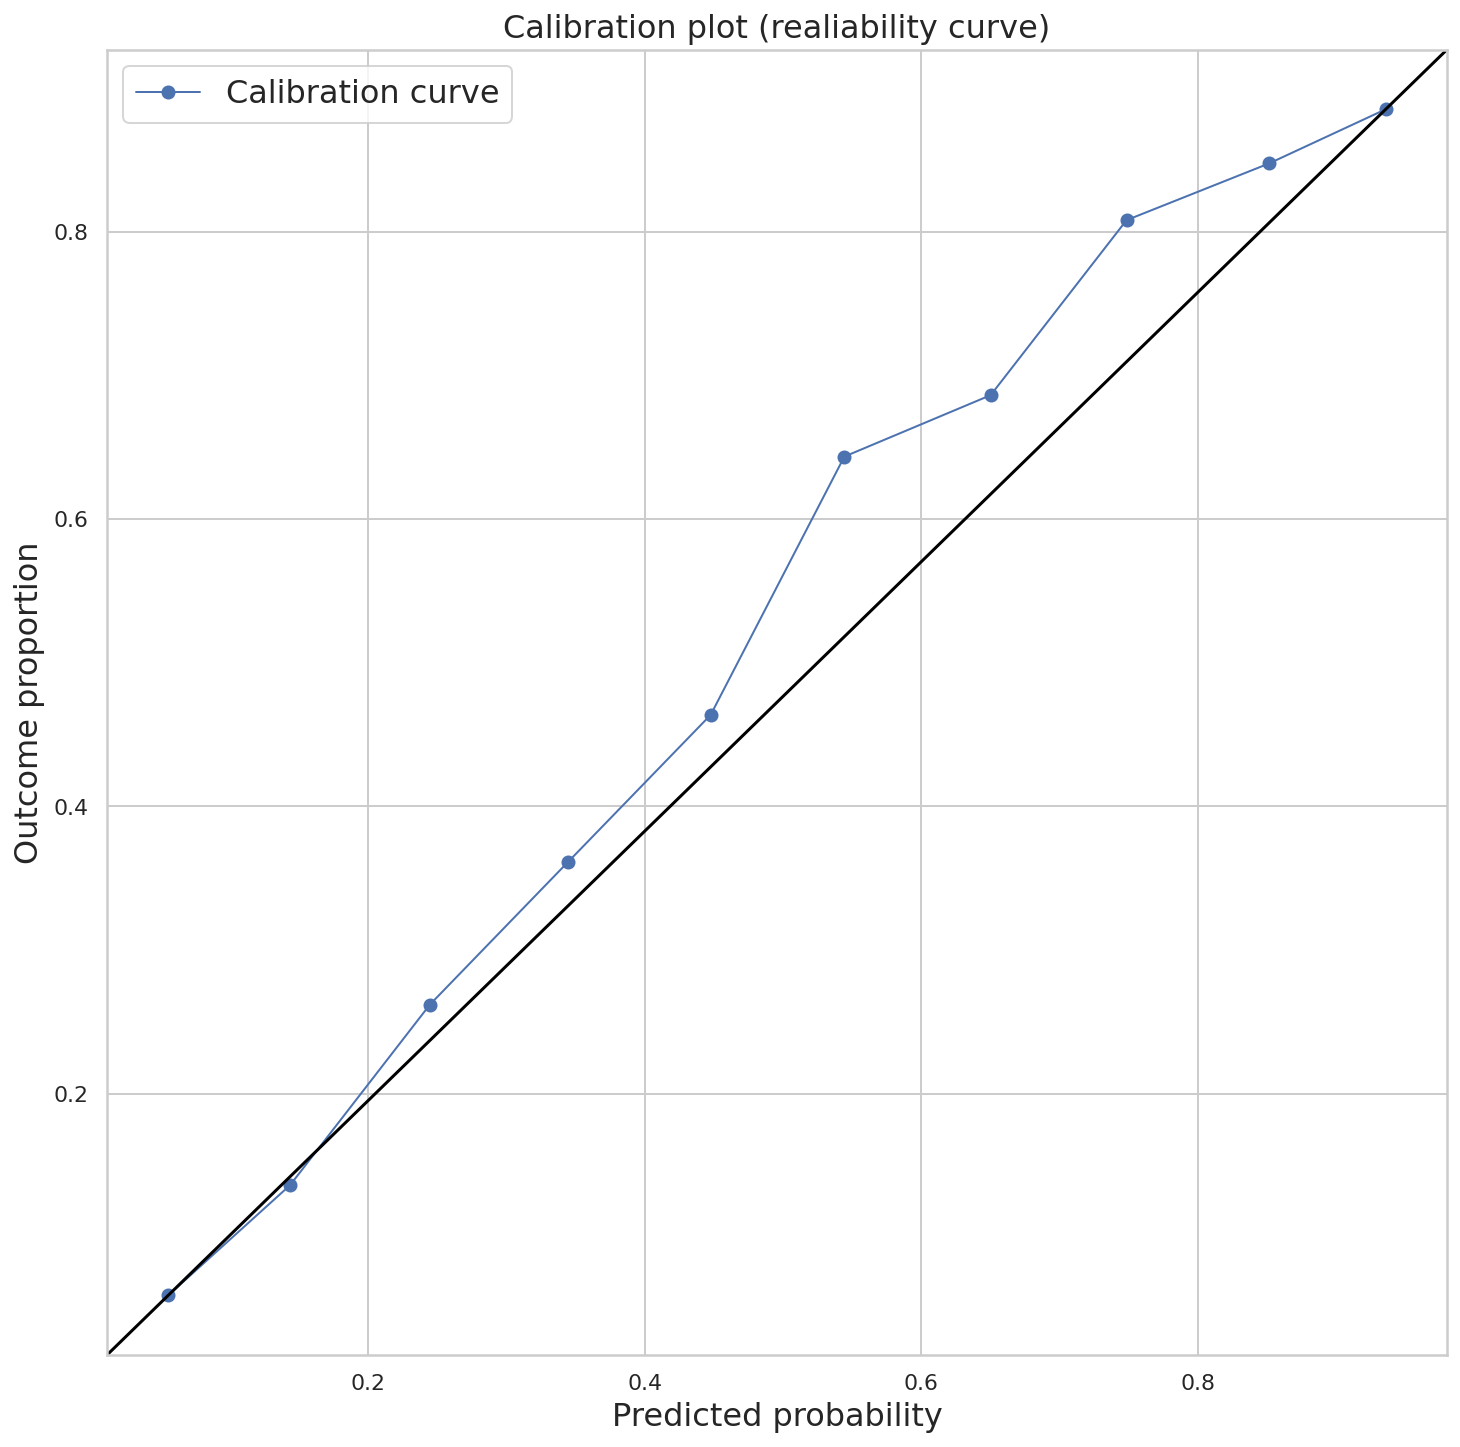

In [35]:
fig, ax = plt.subplots(figsize = (12, 12))
trainer.plot_calibration(ax = ax)
fig.savefig(f"./output/{time_to_readmission}d-calib-{datetime.today().strftime('%Y%m%d')}.png", dpi=300, bbox_inches="tight")